# Analysis Notebook

This notebook is used for the analysis and visualisation of data from the ESM-2 hallucination pipeline.

# Cumulative Log-likelihood and melt temperature.

This cell plots the cumulative log-likelihood and melt temperature over epochs. It is used to demonstrate optimisation for increased thermostability over time. It is normalised to have both on a comparable scale. It takes the last output file of temBERTure as input.

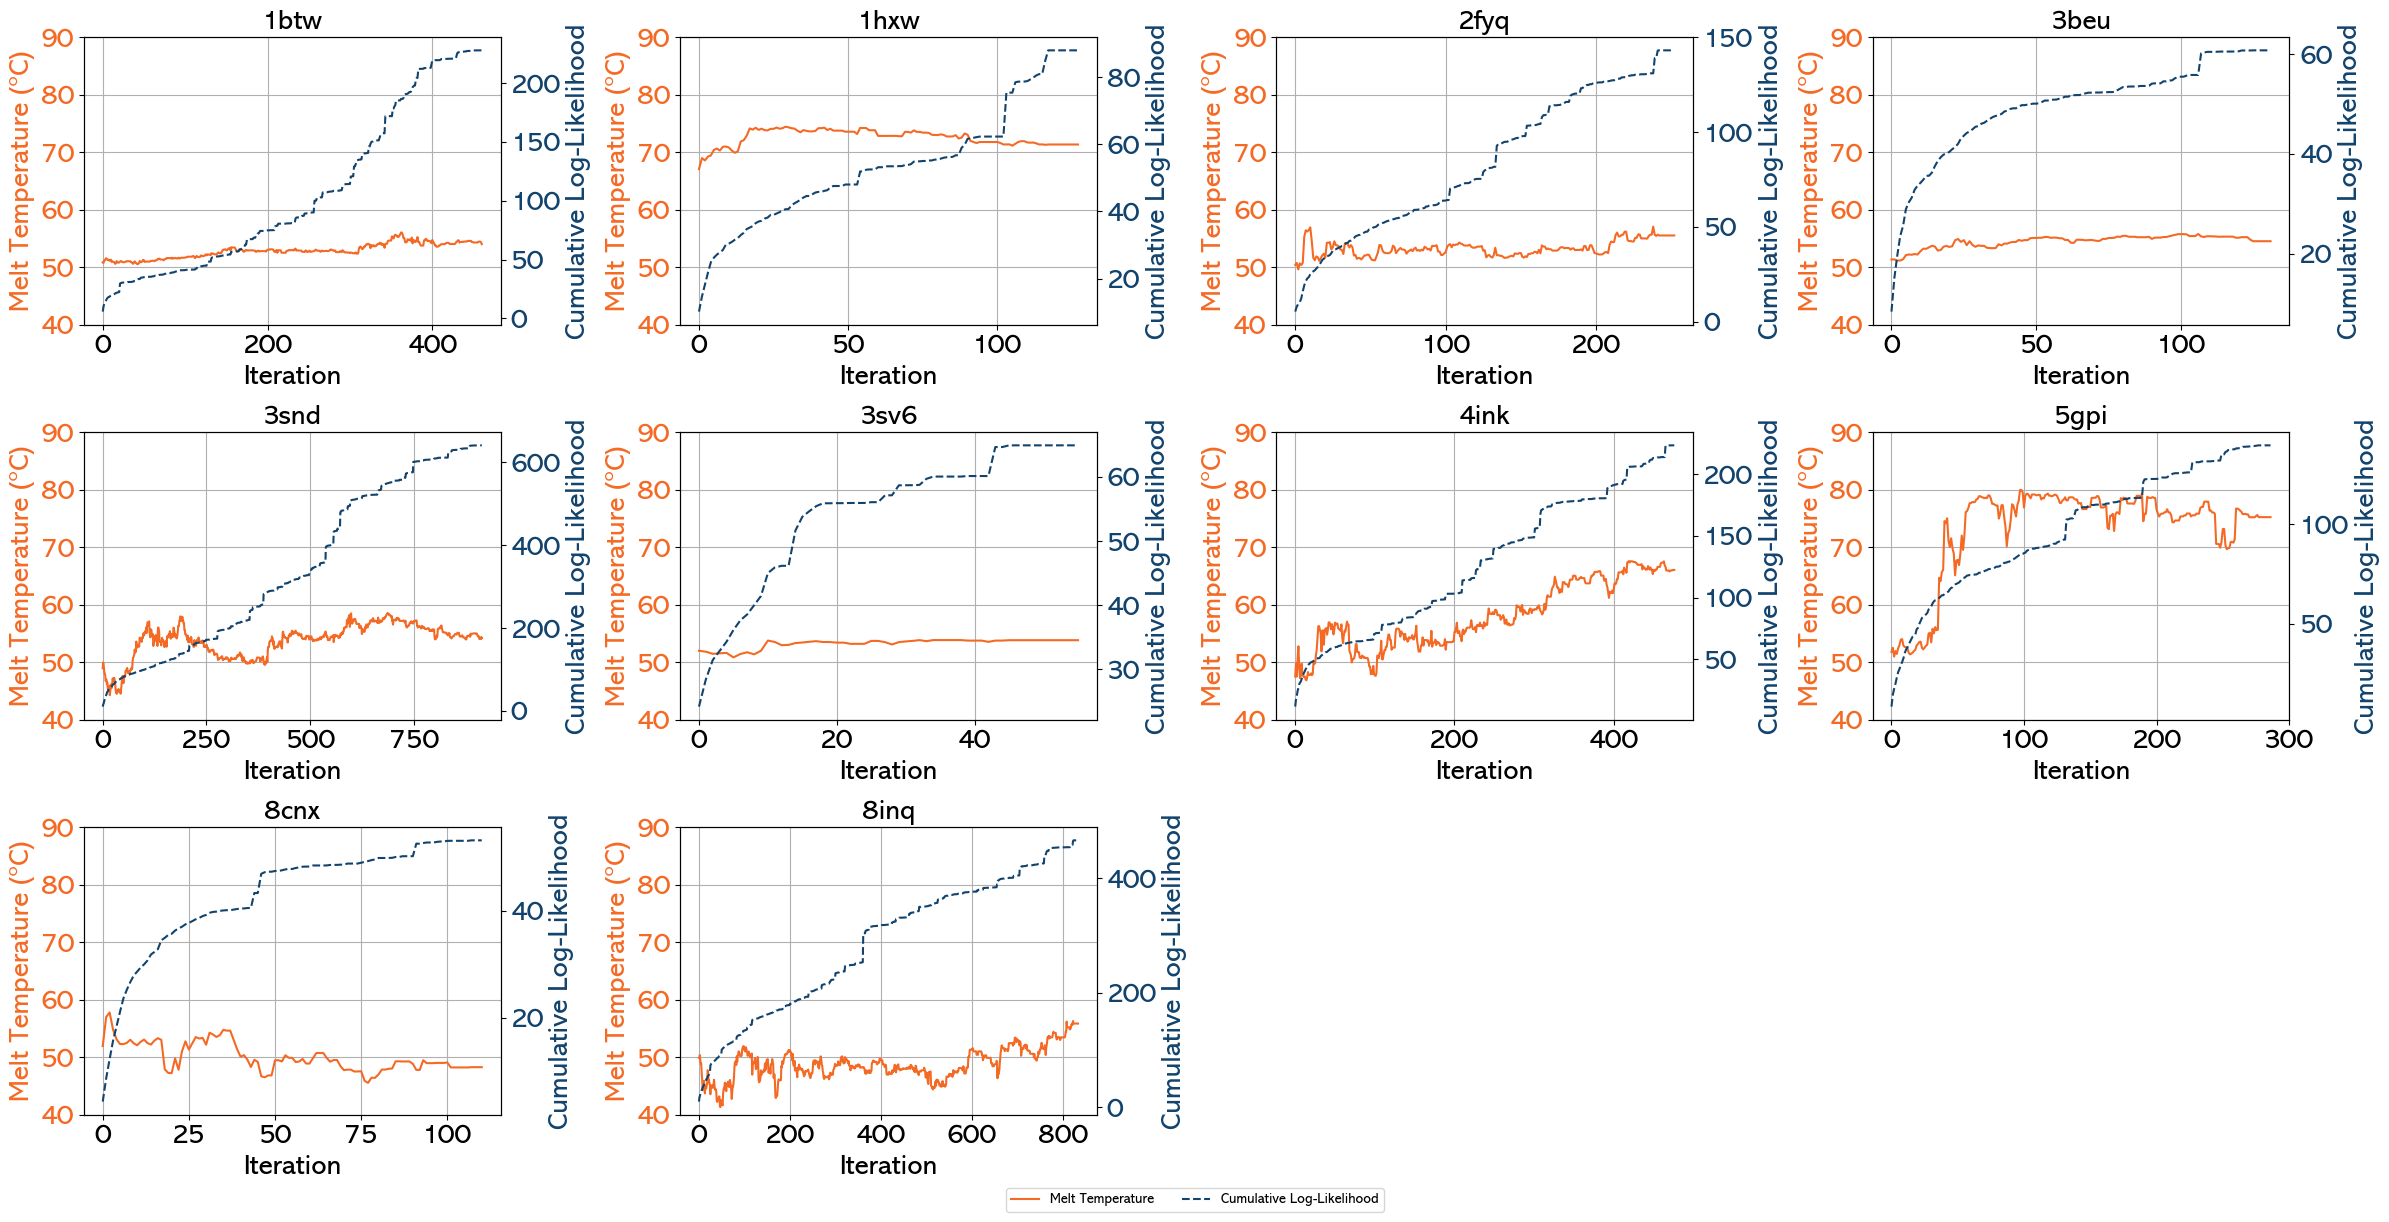

In [9]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# File path
file_path = r"C:\Users\james\Masters_Degree\Thesis\protein_language_model_project\results\temberture_results\protease_best_scores_per_iteration_melt_temps.csv"
# Load data
df = pd.read_csv(file_path)

# Sort
df = df.sort_values(['pdb_id', 'iteration'])

# Exclude problematic proteins
incomplete_pairs = ["2agl", "5ur0", "7mx6", "6i2a"]
df = df[~df['pdb_id'].isin(incomplete_pairs)]

# Compute cumulative score
df['cumulative_score'] = df.groupby('pdb_id')['score'].cumsum()

# Compute derivative of avg_prediction
df['avg_prediction_derivative'] = df.groupby('pdb_id')['avg_melt_temp'].diff()

# Colour palette
duo_palette = {
    'dark_blue': '#12436D',
    'orange': '#F46A25'
}

# Grid size
pdb_ids = df['pdb_id'].unique()
n_plots = len(pdb_ids)
n_cols = math.ceil(math.sqrt(n_plots))
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(6 * n_cols, 4 * n_rows),
    squeeze=False
)

for ax, pdb_id in zip(axes.flatten(), pdb_ids):
    group = df[df['pdb_id'] == pdb_id].copy()

    # Left axis: melt temperature
    ax.plot(
        group['iteration'],
        group['avg_melt_temp'],
        color=duo_palette['orange'],
        label='Melt Temperature'
    )
    ax.set_xlabel('Iteration', fontsize=20)
    ax.set_ylabel(
        'Melt Temperature (°C)',
        color=duo_palette['orange'],
        fontsize=20
    )
    ax.set_ylim(40, 90)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelcolor=duo_palette['orange'], labelsize=20)
    ax.grid(True)

    # Add PDB ID title
    ax.set_title(f"{pdb_id}", fontsize=20)

    # Right axis: cumulative log-likelihood
    ax2 = ax.twinx()
    ax2.plot(
        group['iteration'],
        group['cumulative_score'],
        color=duo_palette['dark_blue'],
        linestyle='dashed',
        label='Cumulative Log-Likelihood'
    )
    ax2.set_ylabel(
        'Cumulative Log-Likelihood',
        color=duo_palette['dark_blue'],
        fontsize=20
    )
    ax2.tick_params(axis='y', labelcolor=duo_palette['dark_blue'], labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)

    # Collect legend handles once
    if pdb_id == pdb_ids[0]:
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        handles = lines1 + lines2
        labels = labels1 + labels2

# Hide unused subplots
for i in range(n_plots, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Global legend
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=2
)

plt.tight_layout()
plt.show()


# Amino acid counts and propensity
The following scripts will visualise differences in amino acid counts and propensity. Set the output path to be a new CSV in your results directory.


In [12]:
# Extract row with maximum iteration per pdb_id and save to CSV
max_iteration_rows = df.loc[
    df.groupby('pdb_id')['iteration'].idxmax(),
    ['pdb_id', 'iteration', 'score', 'sequence']
]

output_path = r"C:\Users\james\Masters_Degree\Thesis\protein_language_model_project\results\protease_max_iteration_summary.csv"
max_iteration_rows.to_csv(output_path, index=False)

max_iteration_rows.head()


,pdb_id,iteration,score,sequence
460,1btw,460,0.00002,PSTDDKIVGGKECKPHSQPWQISLQTKKHFCGGSLIHPQWVLSAAH...
588,1hxw,127,-0.00002,KIKEIKEGPYIKIKIEGEEKEMLIDSGSEITIIKEEIYPKNLKEKE...
841,2fyq,252,0.00002,HHHHHHEEEEEEEAAAPWWARVVDFGKGHGVMVSPRLFVTCTHVVP...
973,3beu,131,0.00000,MVGGQRAQQGEFPWMVYLSTGCGGALVAPDVVVTAAHCVAGRGANQ...
1888,3snd,914,0.00000,GQQQQRFGMQMQAPAAMVEVQLGGQKLNGLFADDVLYVPKHAVFSE...


This section counts amino acid propensities and saves them into a new CSV. You shouuld ideally select your results directory for this.

In [15]:
import pandas as pd
from collections import Counter

# ---------------- CONFIG ----------------
family = "protease"
output_csv_props = f"C:\\Users\\james\\Masters_Degree\\Thesis\\protein_language_model_project\\results\\{family}_amino_acid_proportions.csv"
# ----------------------------------------

# Make sure `max_iteration_rows` exists from the previous cell
all_aa = sorted("ACDEFGHIKLMNPQRSTVWY") 
results = []

for _, row in max_iteration_rows.iterrows():
    pdb_id = row['pdb_id']
    seq = row['sequence']
    length = len(seq)

    counts = Counter(seq)
    data = {
        "pdb_id": pdb_id,
        "iteration": row['iteration'],
        "score": row['score'],
        "length": length
    }
    for aa in all_aa:
        prop = counts.get(aa, 0) / length if length > 0 else 0
        data[f"{aa}_prop"] = prop

    results.append(data)

# Create DataFrame and save
df_props = pd.DataFrame(results)
df_props.to_csv(output_csv_props, index=False)

print(f"Saved amino acid proportions to {output_csv_props}")
df_props.head()


Saved amino acid proportions to C:\Users\james\Masters_Degree\Thesis\protein_language_model_project\results\protease_amino_acid_proportions.csv


,pdb_id,iteration,score,length,A_prop,C_prop,D_prop,E_prop,F_prop,G_prop,H_prop,I_prop,K_prop,L_prop,M_prop,N_prop,P_prop,Q_prop,R_prop,S_prop,T_prop,V_prop,W_prop,Y_prop
0,1btw,460,0.00002,229,0.030568,0.052402,0.030568,0.026201,0.017467,0.082969,0.030568,0.052402,0.200873,0.078603,0.013100,0.026201,0.065502,0.034934,0.017467,0.082969,0.061135,0.052402,0.021834,0.021834
1,1hxw,127,-0.00002,99,0.020202,0.000000,0.030303,0.151515,0.000000,0.080808,0.000000,0.242424,0.181818,0.080808,0.010101,0.020202,0.070707,0.010101,0.010101,0.020202,0.050505,0.000000,0.000000,0.020202
2,2fyq,252,0.00002,194,0.231959,0.025773,0.036082,0.077320,0.051546,0.123711,0.061856,0.005155,0.041237,0.103093,0.005155,0.000000,0.056701,0.015464,0.051546,0.015464,0.025773,0.046392,0.015464,0.010309
3,3beu,131,0.00000,224,0.107143,0.026786,0.031250,0.026786,0.017857,0.116071,0.004464,0.026786,0.004464,0.049107,0.022321,0.062500,0.049107,0.071429,0.071429,0.075893,0.049107,0.107143,0.013393,0.066964
4,3snd,914,0.00000,306,0.088235,0.013072,0.049020,0.052288,0.055556,0.084967,0.009804,0.006536,0.068627,0.055556,0.062092,0.042484,0.052288,0.133987,0.019608,0.058824,0.029412,0.104575,0.000000,0.013072


# Sequence property analysis

This section plots out changes in propensity across proteins, and broadly analyses physiochemical properties of sequences.

The original analysis utilises a results table manually collated by copying the output of previous steps. 

Hydropathy, Aromaticity, instability index, aliphatic index, iso-electric point, net positive and net negative count were omitted from the final analysis for brevity. These are available in the attached results table however, and the below script can be run on them. The counts for sec structure proportion were based off a Biopython analysis off sequence. These were omitted due to use of Foldseek for finding folds, and DSSP being a superior method, which was omitted from the analysis for brevity. Flexibility on Biopython was originally captured, but not used in the analysis, due to the superiority of molecular dynamics methods, but their computational expense proscribed their use.

For refactoring into an automated pipeline however, it is necessary to have an addition script that collates previous results from temberture and evoprotgrad, and for each protein, for wild-type and variant, have the columns:

Protein family: ['family']

Protein: ['pdb_id']

Wild type or variant: ['wt_or_var']

Sequence: ['sequence']

Average Melt Temperature: ['avg_melt_temp']

Hydropathy: ['gravy']

All 20 proteinogenic amino acids (where {X} is one letter code in capital letter): ['{X}_prop']


These are the other columns utilised. 

This cell will print visualisations for Aromaticity, instability, aliphatic index, hydropathy, sec structure %, flexibility, but these are redundant and not used in this analysis. Their functionality is maintained however, as they may yield insights in the future if large datasets are analysed.

If you don't have Abadi installed as a font, just remove the font_manager and font_prop parts of code, or use them to define a font you do have. Or install Abadi, it's a nice font.

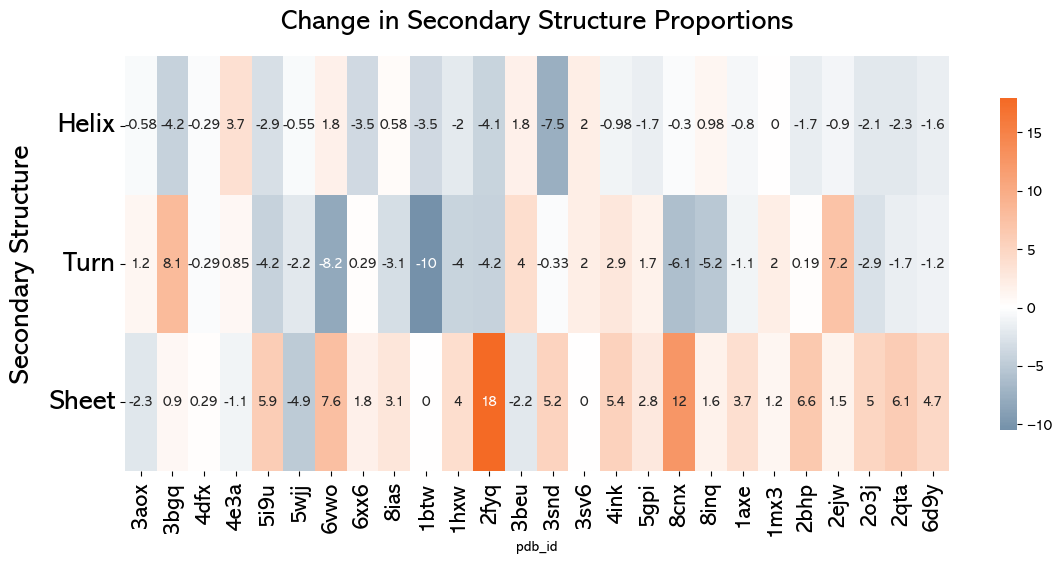

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values.index, y=values.values, palette=colours)


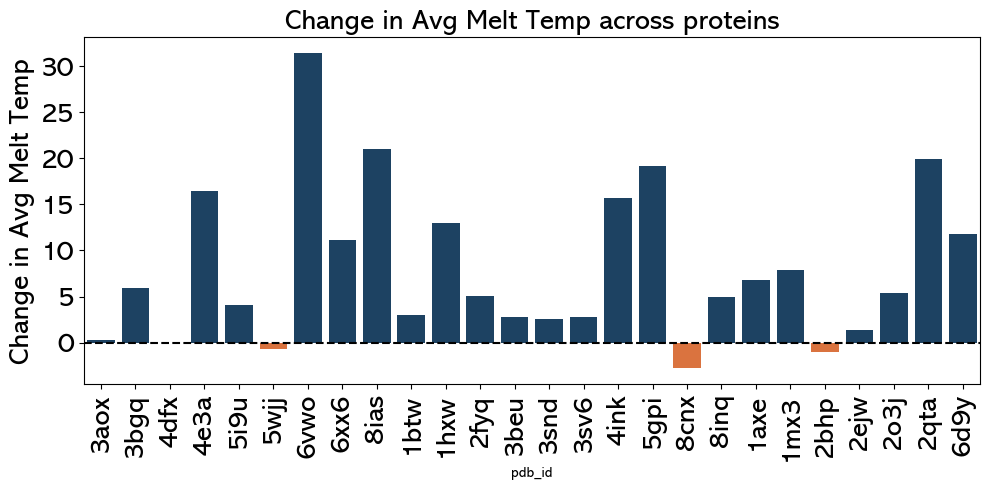

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values.index, y=values.values, palette=colours)


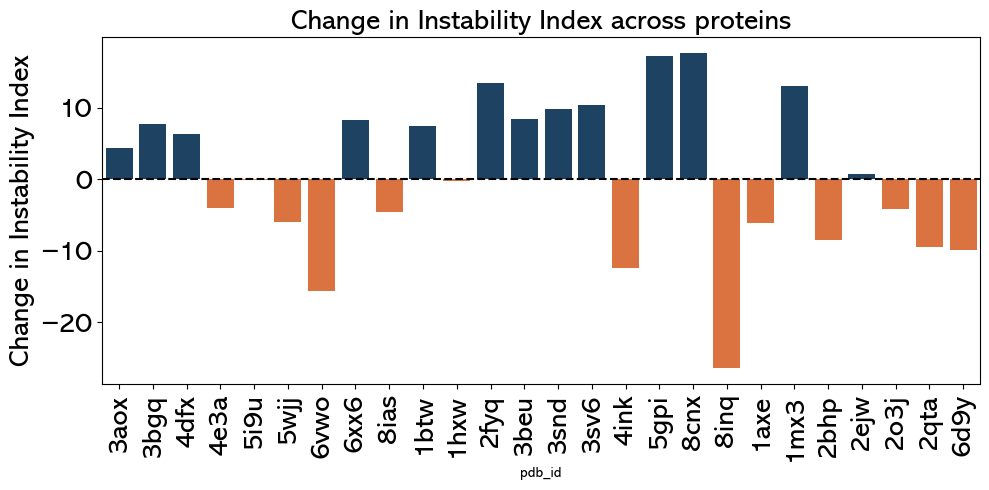

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values.index, y=values.values, palette=colours)


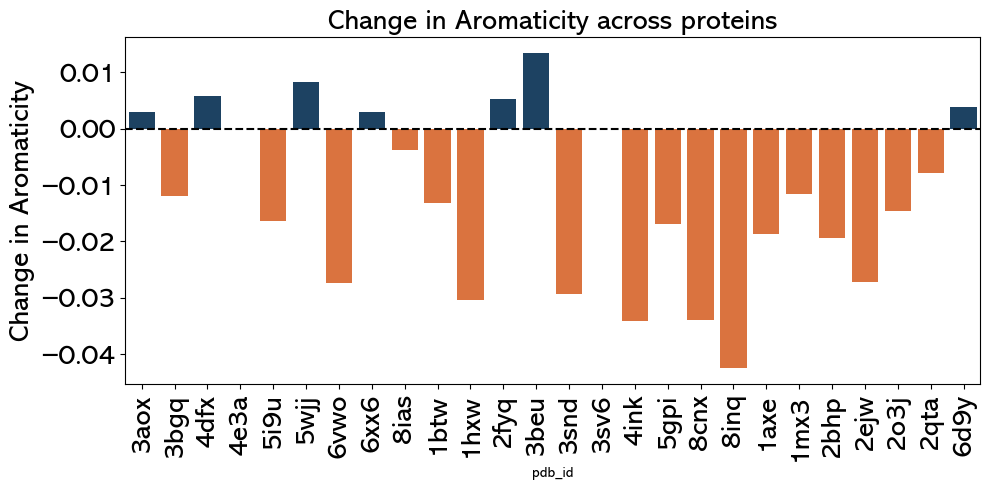

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values.index, y=values.values, palette=colours)


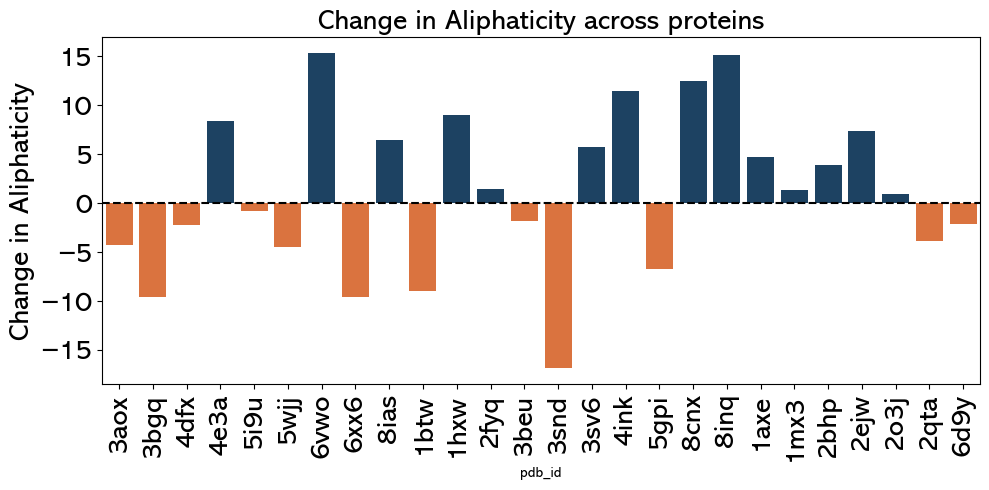

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values.index, y=values.values, palette=colours)


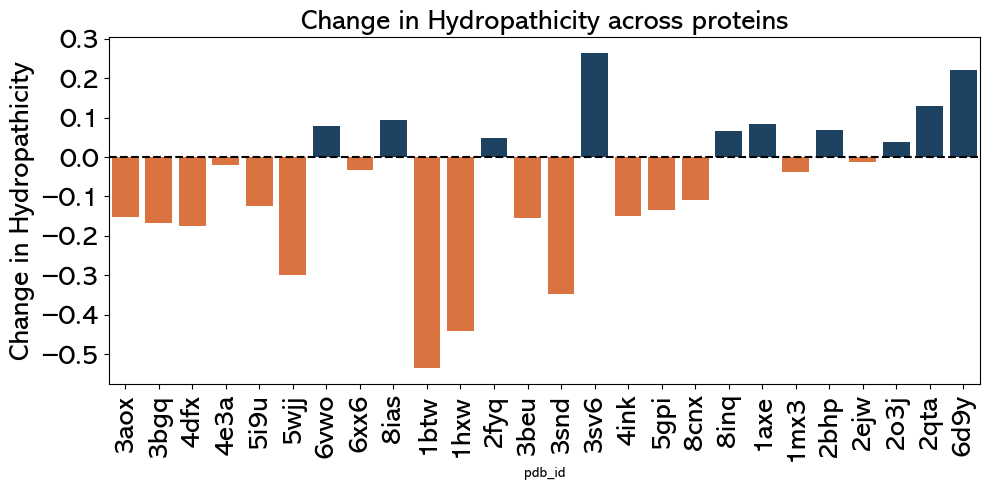

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values.index, y=values.values, palette=colours)


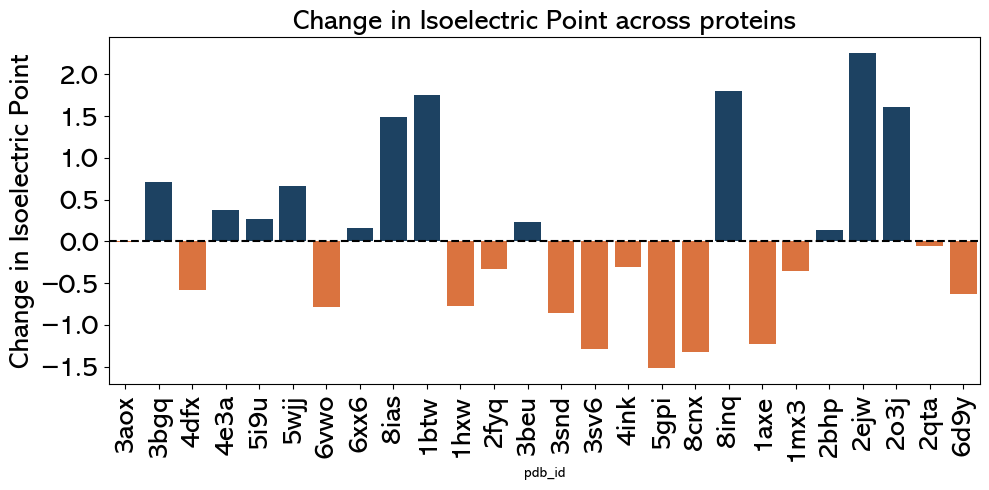

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values.index, y=values.values, palette=colours)


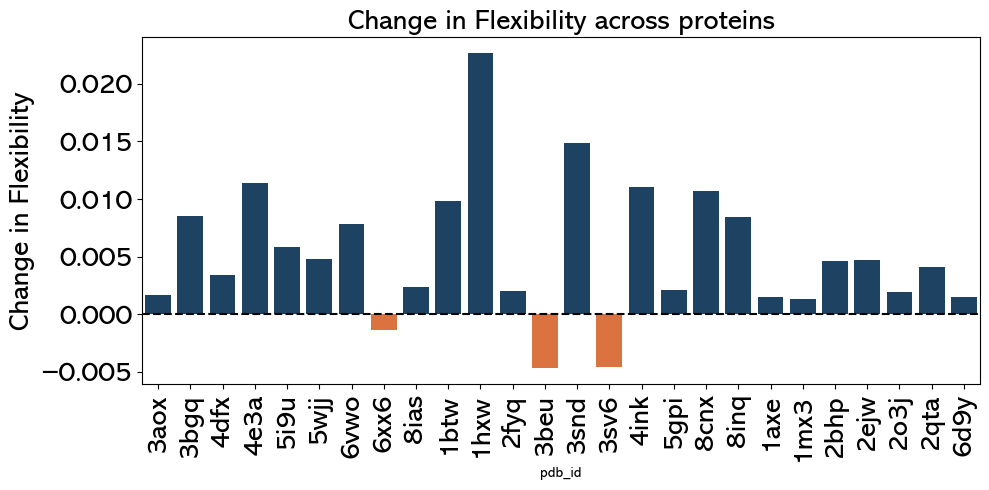

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weighted_avg_change_aa.index, y=weighted_avg_change_aa.values, palette=colours)


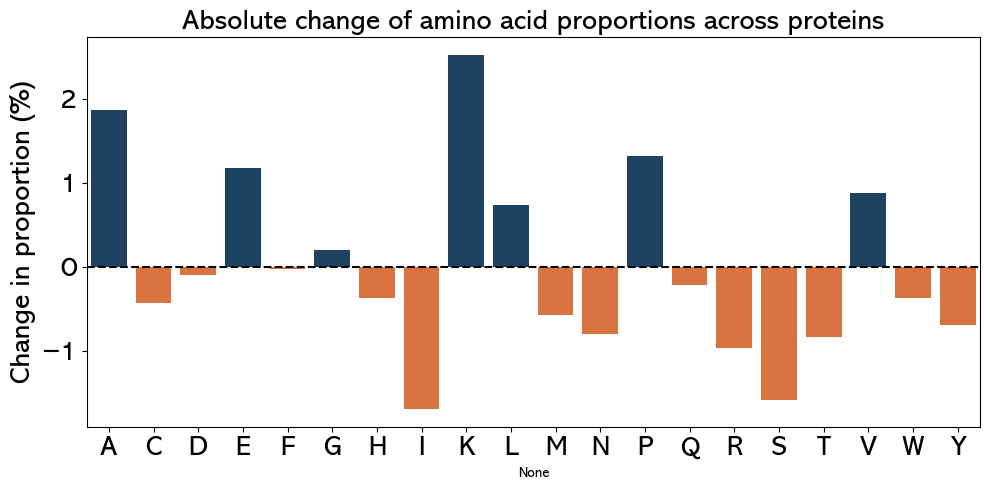

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=net_change_aa.index, y=net_change_aa.values, palette=colours)


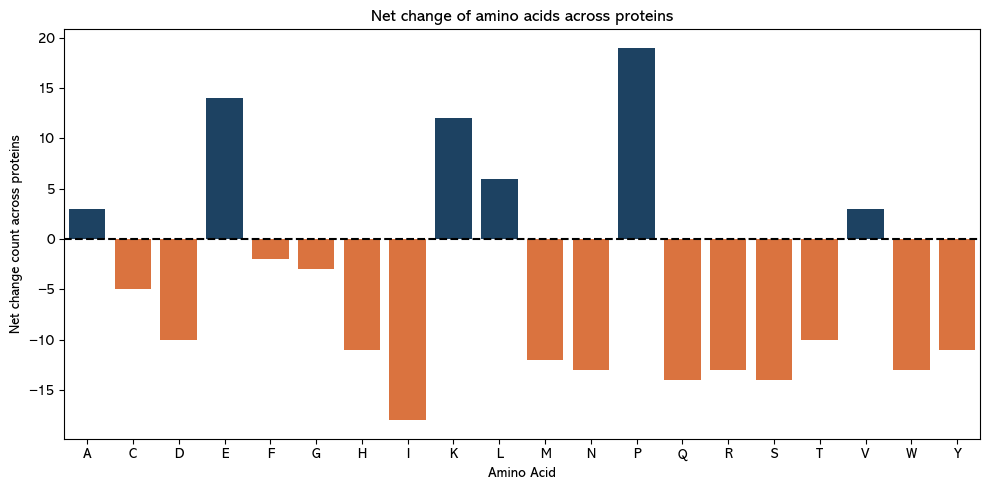

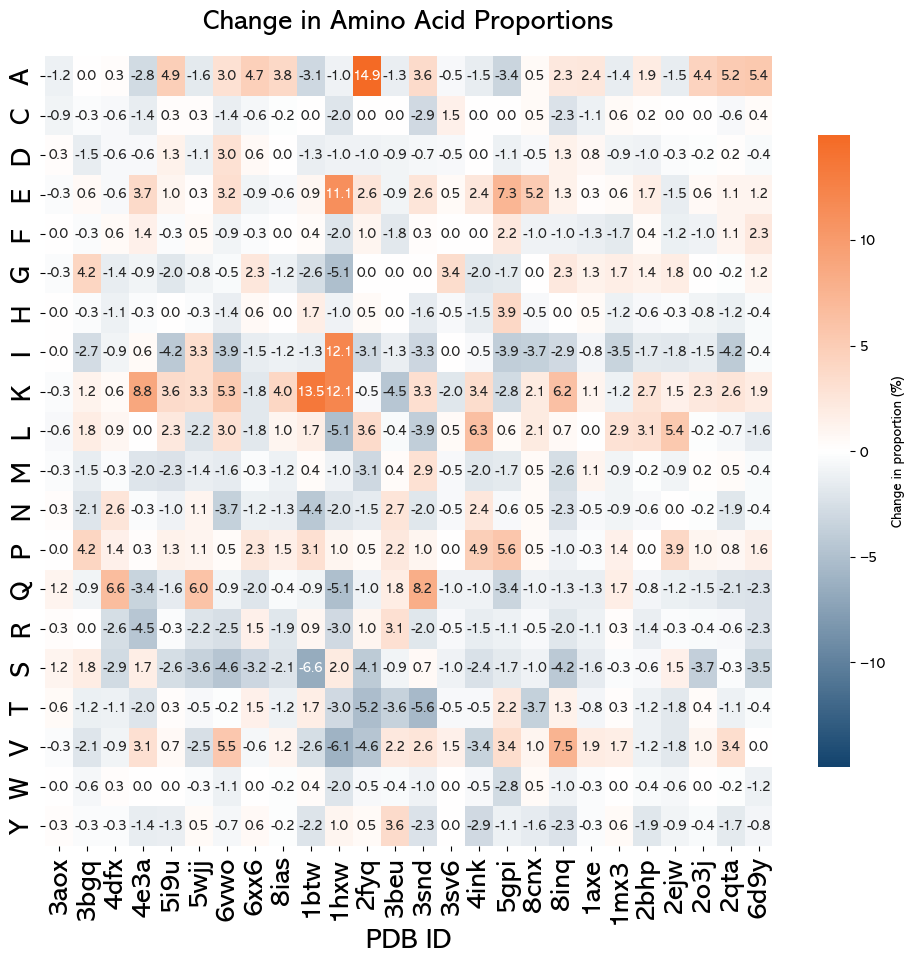

C:\Users\james\AppData\Local\Temp\ipykernel_12780\554549139.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_pct_change_aa.index, y=total_pct_change_aa.values, palette=colours)


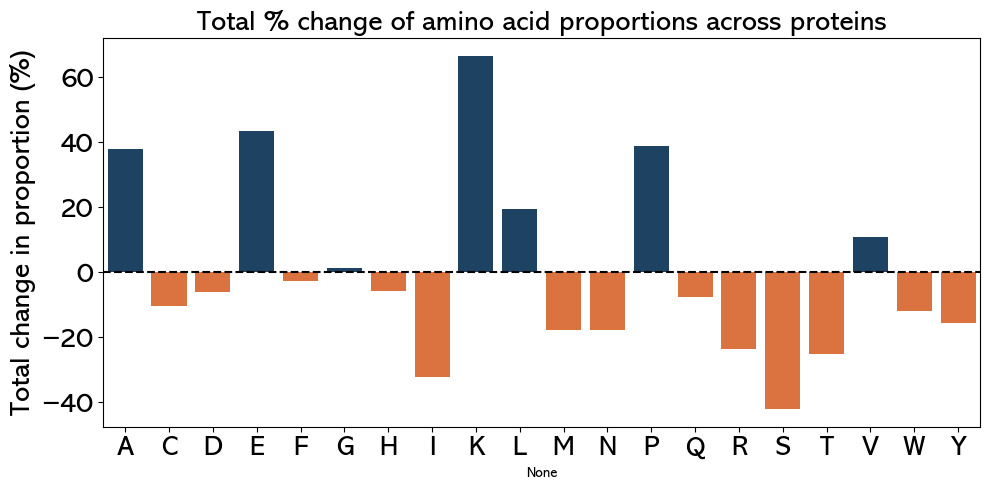

In [29]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import pandas as pd

# ----------------- CONFIG -----------------
results_csv = r"C:\Users\james\Masters_Degree\Thesis\protein_language_model_project\supplementary_data\results_table.csv"
# ------------------------------------------

# Palette and colormap
duo_palette = {'dark blue': '#12436D', 'orange': '#F46A25'}
colors = [(0, "#12436D"), (0.5, "white"), (1, "#F46A25")]
accessible_cmap = LinearSegmentedColormap.from_list("darkblue_white_orange", colors)

# Load dataset with wt/var info
df = pd.read_csv(results_csv)
incomplete_pairs = ["2agl", "5ur0", "7mx6", "6i2a"]

wt = df[df['wt_or_var'] == 'wt'].set_index('pdb_id')
var = df[df['wt_or_var'] == 'var'].set_index('pdb_id')
wt = wt[~wt.index.isin(incomplete_pairs)]
var = var[~var.index.isin(incomplete_pairs)]

# ---------------- Secondary structure deltas ----------------
delta_helix = (var['sec_struc_helix'] - wt['sec_struc_helix']) * 100
delta_turn = (var['sec_struc_turn'] - wt['sec_struc_turn']) * 100
delta_sheet = (var['sec_struc_sheet'] - wt['sec_struc_sheet']) * 100

secstruc_deltas = pd.DataFrame({'Helix': delta_helix, 'Turn': delta_turn, 'Sheet': delta_sheet})

plt.figure(figsize=(12, 6))
sns.heatmap(secstruc_deltas.T, annot=True, cmap=accessible_cmap,
            square=False, cbar_kws={"shrink": 0.8}, center=0)
plt.title("Change in Secondary Structure Proportions", pad=20, fontsize=20)
plt.ylabel("Secondary Structure", labelpad=10, fontsize=20)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=20, rotation=0)
plt.tight_layout(pad=2)
plt.show()

# ---------------- Stability/physchem deltas ----------------
deltas_temp = var['avg_melt_temp'] - wt['avg_melt_temp']
deltas_instability = var['instability_index'] - wt['instability_index']
delta_aromaticity = var['aromaticity'] - wt['aromaticity']
delta_aliphatic = var['aliphatic_index'] - wt['aliphatic_index']
delta_gravy = var['gravy'] - wt['gravy']
delta_isoelectric = var['isoelectric_point'] - wt['isoelectric_point']
delta_flex = var['flexibility_mean'] - wt['flexibility_mean']

df_deltas_vertical = pd.DataFrame({
    'avg_melt_temp': deltas_temp,
    'instability_index': deltas_instability,
    'aromaticity': delta_aromaticity,
    'aliphaticity': delta_aliphatic,
    'Hydropathicity': delta_gravy,
    'isoelectric_point': delta_isoelectric,
    'Flexibility': delta_flex
})

for col in df_deltas_vertical.columns:
    values = df_deltas_vertical[col]
    colours = [duo_palette['orange'] if v <= 0 else duo_palette['dark blue'] for v in values]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=values.index, y=values.values, palette=colours)
    plt.axhline(0, color='black', linestyle='--')
    plt.ylabel(f"Change in {col.replace('_',' ').title()}", fontsize=20)
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    plt.title(f"Change in {col.replace('_',' ').title()} across proteins", fontsize=20)
    plt.tight_layout()
    plt.show()

# ---------------- Amino acid deltas ----------------
amino_acid_props = [f"{aa}_prop" for aa in "ACDEFGHIKLMNPQRSTVWY"]

df_aa_deltas_pct = (var[amino_acid_props] - wt[amino_acid_props]) * 100
df_aa_deltas_pct_T = df_aa_deltas_pct.transpose()

# Weighted average change
wt['length'] = wt['sequence'].str.len()
var['length'] = var['sequence'].str.len()
avg_lengths = (wt['length'] + var['length']) / 2

weighted_deltas = df_aa_deltas_pct_T * avg_lengths.values
total_residues = avg_lengths.sum()
weighted_avg_change_aa = weighted_deltas.sum(axis=1) / total_residues
weighted_avg_change_aa.index = [aa.replace('_prop', '') for aa in weighted_avg_change_aa.index]

plt.figure(figsize=(10, 5))
colours = [duo_palette['orange'] if v <= 0 else duo_palette['dark blue'] for v in weighted_avg_change_aa.values]
sns.barplot(x=weighted_avg_change_aa.index, y=weighted_avg_change_aa.values, palette=colours)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("Change in proportion (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Absolute change of amino acid proportions across proteins", fontsize=20)
plt.tight_layout()
plt.show()

# Net change counts
sign_matrix = np.sign(df_aa_deltas_pct_T)
df_aa_deltas_pct_T.index = [aa.replace('_prop','') for aa in df_aa_deltas_pct_T.index]
sign_matrix.index = df_aa_deltas_pct_T.index
net_change_aa = sign_matrix.sum(axis=1)

plt.figure(figsize=(10, 5))
colours = [duo_palette['orange'] if v <= 0 else duo_palette['dark blue'] for v in net_change_aa.values]
sns.barplot(x=net_change_aa.index, y=net_change_aa.values, palette=colours)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("Net change count across proteins")
plt.xlabel("Amino Acid")
plt.title("Net change of amino acids across proteins")
plt.tight_layout()
plt.show()

# Heatmap of per-protein amino acid deltas
plt.figure(figsize=(10, 10))
max_abs = np.abs(df_aa_deltas_pct_T.values).max()
sns.heatmap(df_aa_deltas_pct_T, annot=True, fmt=".1f",
            cmap=accessible_cmap, center=0,
            vmin=-max_abs, vmax=max_abs,
            cbar_kws={"label": "Change in proportion (%)", "shrink": 0.8})
plt.title("Change in Amino Acid Proportions", pad=20, fontsize=20)
plt.xlabel("PDB ID", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tight_layout(pad=2)
plt.show()

# Total % change across all proteins
total_pct_change_aa = df_aa_deltas_pct_T.sum(axis=1)
plt.figure(figsize=(10, 5))
colours = [duo_palette['orange'] if v <= 0 else duo_palette['dark blue'] for v in total_pct_change_aa.values]
sns.barplot(x=total_pct_change_aa.index, y=total_pct_change_aa.values, palette=colours)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("Total change in proportion (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Total % change of amino acid proportions across proteins", fontsize=20)
plt.tight_layout()
plt.show()
